# Unsupervised Learning Techniques

## Clustering

In [1]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

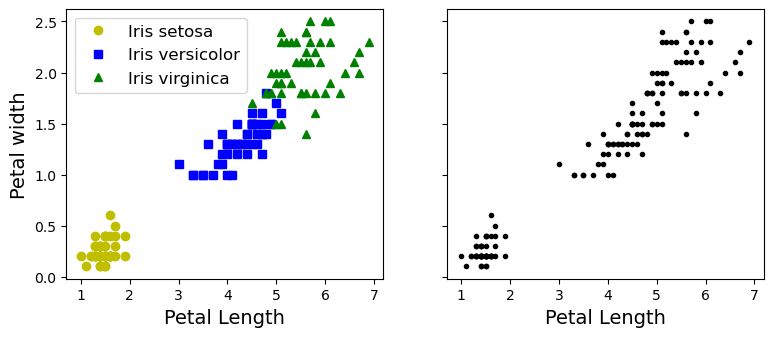

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:,2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal Length", fontsize=14)
plt.tick_params(labelleft=False)
plt.show()

Consider above figure: on the left is the iris dataset, where
each instance’s species (i.e., its class) is represented with a different
marker. It is a labeled dataset, for which classification algorithms such as
Logistic Regression, SVMs, or Random Forest classifiers are well suited.
On the right is the same dataset, but without the labels, so we cannot use a
classification algorithm anymore. This is where clustering algorithms step
in: many of them can easily detect the lower-left cluster. It is also quite
easy to see with our own eyes, but it is not so obvious that the upper-right
cluster is composed of two distinct sub-clusters. That said, the dataset has
two additional features (sepal length and width), not represented here, and
clustering algorithms can make good use of all features, so in fact they
identify the three clusters fairly well (e.g., using a Gaussian mixture
model, only 5 instances out of 150 are assigned to the wrong cluster).

### K-Means

Consider the unlabelled dataset represented in below figure

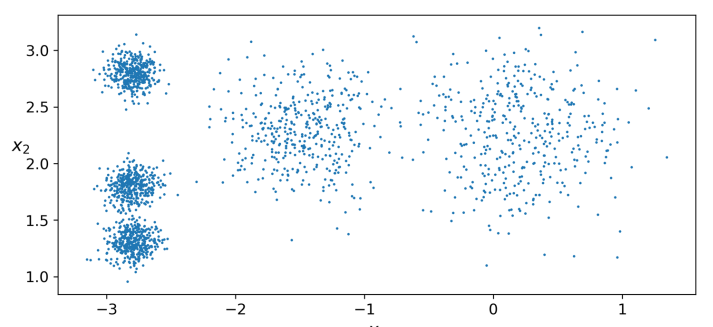

We can clearly see five blob of instances. The K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in few iterations. Sometimes referred as Lloyd-Forgy. 

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [2]:
from sklearn.datasets import make_blobs
import numpy as np

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [40]:
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

Note that we have to specify the number of clusters *k* that the algorithm
must find. In this example, it is pretty obvious from looking at the data
that k should be set to 5, but in general it is not that easy.

In [41]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
y_pred = kmeans.fit_predict(X)

In [42]:
y_pred

array([1, 1, 4, ..., 3, 2, 1], dtype=int32)

Each instance was assigned to one of the 5-clusters. In the context of
clustering, an instance’s *label* is the index of the cluster that this instance
gets assigned to by the algorithm: this is not to be confused with the class
labels in classification (remember that clustering is an unsupervised
learning task).

The `KMeans` instance preserves a copy of the labels of the
instances it was trained on, available via the `labels_` instance variable:

In [29]:
y_pred is kmeans.labels_

True

And following 5 *centeroids* (i.e., cluster centers) were estimated:

In [43]:
kmeans.cluster_centers_

array([[-1.46893704,  2.28372774],
       [-2.80214068,  1.55162671],
       [ 0.18304455,  2.55635115],
       [-2.79290307,  2.79641063],
       [ 0.23444426,  1.90682419]])

We can easily assign new instances to the cluster whose centroid is
closest:

In [44]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

If we plot the cluster’s decision boundaries, we get a Voronoi tessellation

In [50]:
import matplotlib.pyplot as plt

In [49]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

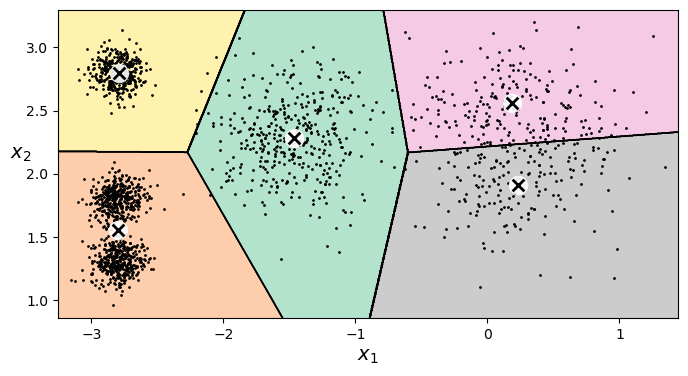

In [51]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate
cluster, but a few instances were probably mislabeled (especially near the
boundary between the top-left cluster and the central cluster). Indeed, the
K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

Instead of assigning each instance to a single cluster, which is called `hard clustering`, it can be useful to give each instance a score per cluster, which is called `soft clustering`. The score can be the distance between the instance and the centeroid; conversely it can be a similarity score (or affinity) such as Gaussian Radial Bias function. 

In `KMeans` class, the `transform()` method measures the distance from each instance to every centeroid:

In [53]:
kmeans.transform(X_new)

array([[1.49608739, 2.83778629, 0.58568926, 2.9042344 , 0.25228128],
       [4.47793476, 5.81943941, 2.87136981, 5.84739223, 2.76712491],
       [1.69032533, 1.4618254 , 3.21381346, 0.29040966, 3.41418556],
       [1.54626242, 0.96879317, 3.18354332, 0.36159148, 3.28838672]])

In this example, the first instance of `X_new` ([0,2]) is located at distance 1.49 from the first centeroid, 2.83 from the second, 0.58 from the third, 2.90 from fourth and 0.29 from 5th. If we have a high-dimensional dataset and we transform it this way, we end up with a k-dimensional dataset: this transformation can be very efficient nonlinear dimensionality reduction technique.

we can see the algorithm in action in below figure: the centroids are
initialized randomly (top left), then the instances are labeled (top right),
then the centroids are updated (center left), the instances are relabeled
(center right), and so on. As we can see, in just three iterations, the
algorithm has reached a clustering that seems close to optimal.

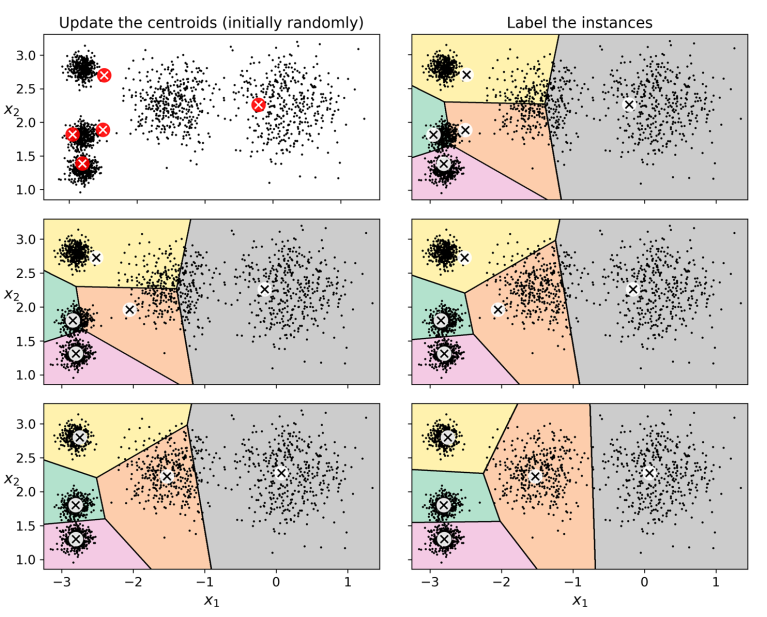

#### Centeroid Initialization Techniques

If we know approximately where the centeroids should be (e.g., if we ran another clustering algorithm earlier), then we can set the `init` hyperparameter to a Numpy array containing the list of centeroids, and set `n_init` to 1.

In [56]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

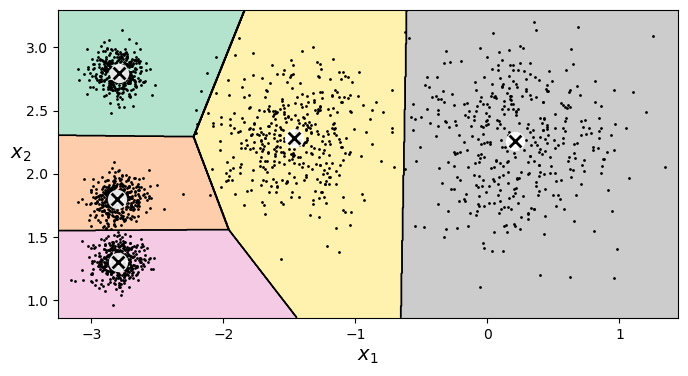

In [57]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

This is perfect plot as compared to earlier, so this centeroid initiazliation is much better

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. The number of random initializations is controlled by `n_init` hyperparameter: by default it is equal to 10, which means the whole algorithm described earlier runs 10 times when we call `fit()`, and Scikit-Learn keeps the best solution.

But how exactly does it know which solution is best? It uses a performance metric! That metric is called the model's `inertia`, which is the mean squared distance between each instance and its closest centeroid. Then `KMeans` class runs the algorithm `n_init` times and keeps the model with lowest inertia. A model's `inertia` is accessible via the `inertia_` instance variabel:

In [58]:
kmeans.inertia_

211.59853725816836

The `score()` method returns the negative inertia.

In [59]:
kmeans.score(X)

-211.59853725816836

Why negative? Because a predictor's `score()` method must always respect Scikit-Learn's "greater is better" rule: if a predictor is better than another, its `score()` should return a greator score.

An important improvement to the K-means algorithm, is K-Means++ . Authors introduced a smarter initialization step that tends to select centeroids that are distant from one another, and this improvement makes the K-Means much less likely to converge to suboptimal solution. They showed that the additional computation required for the smarter initialization step is well worth it because it makes it possible to drastically reduce the number of algorithm needs to be run to find the optimal solution. 

The `KMeans` class uses `KMeans++` initialization method by default. If we want to force it to use the original method (i.e., picking *k* instances randomly to define intial centeroids), then we can set the `init` hyperparameter to `"random"`. We will rarely need to do this.

#### Accelerated K-Means and mini-batch K-Means

Accelerated K-Means algorithm `KMeans` class uses by default (we can force it to use the original algorithm by setting the `algorithm` hyperparameter to `full`, although we probably will never need to).

Scikit Learn implements mini-batch K-Means in the `MiniBatchKMeans` class

In [61]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init="auto")
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init='auto')

In [62]:
minibatch_kmeans.inertia_

211.62764025925281